In [1]:
%matplotlib inline

In [86]:
import os
import re
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [11]:
_dir = "./dataset2/KDEF/"

In [24]:
feelings = {"AF": "afraid",
        "AN" : "angry",
        "DI" : "disgusted",
        "HA" : "happy",
        "NE" : "neutral",
        "SA" : "sad",
        "SU" : "surprised"}
angles = {
    "FL" : "full left profile",
    "HL" : "half left profile",
    "S" : "straight",
    "HR" : "half right profile",
    "FR" : "full right profile",
}

In [25]:
print feelings, angles

{'DI': 'disgusted', 'AF': 'afraid', 'NE': 'neutral', 'SU': 'surprised', 'AN': 'angry', 'SA': 'sad', 'HA': 'happy'} {'HR': 'half right profile', 'S': 'straight', 'FL': 'full left profile', 'FR': 'full right profile', 'HL': 'half left profile'}


In [53]:
cates = {}
for root, dirs, files in os.walk(_dir, topdown=False):
    for name in files:
        fn = os.path.join(root, name)
        if not re.search("JPG$", fn):
            continue
        
        cate = name.split(".JPG")[0][4:6]
        ang  = name.split(".JPG")[0][6:]
        if not cate in cates:
            cates[cate] = {}
        if not ang in cates[cate]:
            cates[cate][ang] = []
        cates[cate][ang].append(fn)

In [87]:
def concat_images(imga, imgb):
    """
    Combines two color image ndarrays side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    total_width = wa+wb
    new_img = np.zeros(shape=(max_height, total_width, 3), dtype=np.uint8)
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    return new_img

In [92]:
con_im = cv2.imread(cates['HA']["S"][0], cv2.IMREAD_COLOR)
for fu in feelings:
    print fu
    im = cv2.imread(cates[fu]["S"][0], cv2.IMREAD_COLOR)
    con_im = concat_images(con_im, im)

DI
AF
NE
SU
AN
SA
HA


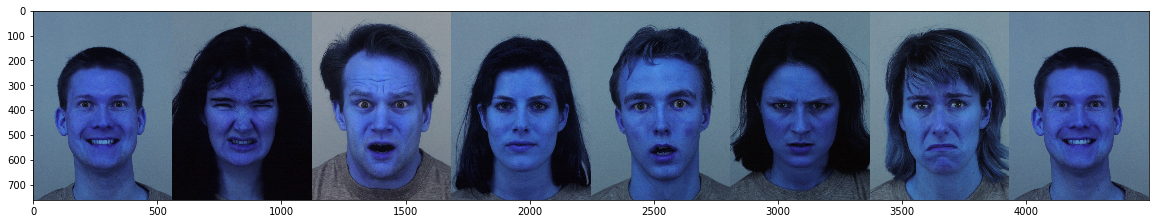

In [95]:
plt.figure(figsize=(20,10))
plt.imshow(con_im)

# building models
http://www.paulvangent.com/2016/08/05/emotion-recognition-using-facial-landmarks/

In [66]:
import cv2
import glob
import random
import math
import numpy as np
import dlib
import itertools
from sklearn.svm import SVC

In [67]:
PREDICTOR_PATH = "./shape_predictor_68_face_landmarks.dat"

In [70]:
emotions = feelings.keys()

In [72]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH) #Or set this to whatever you named the downloaded file
clf = SVC(kernel='linear', probability=True, tol=1e-3)#, verbose = True) #Set the classifier as a support vector machines with polynomial kernel

data = {} #Make dictionary for all values
#data['landmarks_vectorised'] = []

In [73]:
def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
            
        xmean = np.mean(xlist)
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist]
        ycentral = [(y-ymean) for y in ylist]

        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))

        data['landmarks_vectorised'] = landmarks_vectorised
    if len(detections) < 1: 
        data['landmarks_vestorised'] = "error"

In [75]:
def get_files(emotion): #Define function to get file list, randomly shuffle it and split 80/20
#     files = glob.glob("dataset\\%s\\*" %emotion)
    files = cates[emotion]["S"]
    random.shuffle(files)
    training = files[:int(len(files)*0.8)] #get first 80% of file list
    prediction = files[-int(len(files)*0.2):] #get last 20% of file list
    return training, prediction

In [82]:
def make_sets():
    training_data = []
    training_labels = []
    prediction_data = []
    prediction_labels = []
    for emotion in emotions:
        print(" working on %s" %emotion)
        training, prediction = get_files(emotion)
        #Append data to training and prediction list, and generate labels 0-7
        for item in training:
            image = cv2.imread(item) #open image
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                training_data.append(data['landmarks_vectorised']) #append image array to training data list
                training_labels.append(emotions.index(emotion))
    
        for item in prediction:
            image = cv2.imread(item)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                prediction_data.append(data['landmarks_vectorised'])
                prediction_labels.append(emotions.index(emotion))

    return training_data, training_labels, prediction_data, prediction_labels   

In [96]:
%%time
accur_lin = []
for i in range(0,10):
    print("Making sets %s" %i) #Make sets by random sampling 80/20%
    training_data, training_labels, prediction_data, prediction_labels = make_sets()

    npar_train = np.array(training_data) #Turn the training set into a numpy array for the classifier
    npar_trainlabs = np.array(training_labels)
    print("training SVM linear %s" %i) #train SVM
    clf.fit(npar_train, training_labels)

    print("getting accuracies %s" %i) #Use score() function to get accuracy
    npar_pred = np.array(prediction_data)
    pred_lin = clf.score(npar_pred, prediction_labels)
    print "linear: ", pred_lin
    accur_lin.append(pred_lin) #Store accuracy in a list

print("Mean value lin svm: %s" %np.mean(accur_lin)) #FGet mean accuracy of the 10 runs

Making sets 0
 working on DI
 working on AF
 working on NE
 working on SU
 working on AN
 working on SA
 working on HA
training SVM linear 0
getting accuracies 0
linear:  0.75
Making sets 1
 working on DI
 working on AF
 working on NE
 working on SU
 working on AN
 working on SA
 working on HA
training SVM linear 1
getting accuracies 1
linear:  0.811224489796
Making sets 2
 working on DI
 working on AF
 working on NE
 working on SU
 working on AN
 working on SA
 working on HA
training SVM linear 2
getting accuracies 2
linear:  0.84693877551
Making sets 3
 working on DI
 working on AF
 working on NE
 working on SU
 working on AN
 working on SA
 working on HA
training SVM linear 3
getting accuracies 3
linear:  0.811224489796
Making sets 4
 working on DI
 working on AF
 working on NE
 working on SU
 working on AN
 working on SA
 working on HA
training SVM linear 4
getting accuracies 4
linear:  0.831632653061
Making sets 5
 working on DI
 working on AF
 working on NE
 working on SU
 workin

In [97]:
predict_fns = ["../dataset/KING.jpg", "../dataset/Lin.jpg", "../dataset/Trump.jpg", "../dataset/GIRL.jpg"]

In [98]:
print(" working on prediction dataset")

predict_data = []
predict_label = []
#Append data to training and prediction list, and generate labels 0-7
for item in predict_fns:
    image = cv2.imread(item) #open image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
    clahe_image = clahe.apply(gray)
    get_landmarks(clahe_image)
    if data['landmarks_vectorised'] == "error":
        print("no face detected on this one")
    else:
        predict_data.append(data['landmarks_vectorised']) #append image array to training data list
#         training_labels.append(emotions.index(emotion))


 working on prediction dataset


In [100]:
predict_res = clf.predict(predict_data)

In [105]:
getFeeling = lambda x: feelings[emotions[x]]

In [106]:
getFeeling(0)

'disgusted'

In [116]:
print "prediction images seq: ", ", ".join([getFeeling(x) for x in predict_res])


prediction images seq:  disgusted, afraid, afraid, afraid


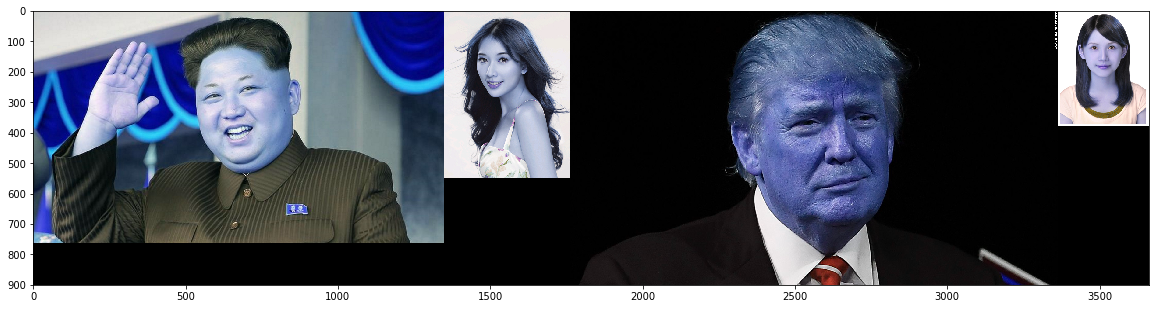

In [114]:
plt.figure(figsize=(20,10))

con_img = cv2.imread(predict_fns[0])
for item in predict_fns[1:]:
    image = cv2.imread(item) #open image
    con_img = concat_images(con_img, image)
plt.imshow(con_img)